# 4. Gyakorlat: Monte Carlo és temporális különbségek

In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

seed = 11
random.seed(seed)
np.random.seed(seed)

## Környezet definiálása
A környezet egy 3 állapotos Markov döntési folyamat, sűrű jutalmakkal. Minden állapotból lehetséges eljutni az összes többibe, ezáltal egy jóval nagyobb cselekvési teret kell az ügynöknek megtanulnia. 

In [2]:
class Environment():
    def __init__(self):
        self.p_s_a = [  # Állapotátmeneti valószínűségek (környezeti dinamika) [s, a, s']
            [[0.0, 0.3, 0.7, 0.0],      # s0 --> a0 --> [s0, s1, s2, s3]
             [0.0, 0.6, 0.4, 0.0],      # s0 --> a1 --> [s0, s1, s2, s3]
             [0.0, 1.0, 0.0, 0.0]],     # s0 --> a2 --> [s0, s1, s2, s3]
            [[0.8, 0.0, 0.2, 0.0],      # s1 --> a0 --> [s0, s1, s2, s3]
             [0.3, 0.0, 0.5, 0.2],      # s1 --> a1 --> [s0, s1, s2, s3]
             [0.0, 0.0, 0.8, 0.2]],     # s1 --> a2 --> [s0, s1, s2, s3]
            [[0.1, 0.9, 0.0, 0.0],      # s2 --> a0 --> [s0, s1, s2, s3]
             [0.4, 0.1, 0.0, 0.5],      # s2 --> a1 --> [s0, s1, s2, s3]
             [0.2, 0.3, 0.0, 0.5]],     # s2 --> a2 --> [s0, s1, s2, s3]
            [[0.0, 0.0, 0.0, 0.0],      # s3 --> a0 --> [s0, s1, s2, s3]
             [0.0, 0.0, 0.0, 0.0],      # s3 --> a1 --> [s0, s1, s2, s3]
             [0.0, 0.0, 0.0, 0.0]],     # s3 --> a2 --> [s0, s1, s2, s3]
        ]

        self.R = [
            [[ -5, 10,  0,  0],         # s0 --> a0 --> [r0, r1, r2, r3]
             [  1,0.0,  0,  0],         # s0 --> a1 --> [r0, r1, r2, r3]
             [ -3,  8,  0,  0]],        # s0 --> a2 --> [r0, r1, r2, r3]
            [[  0, -1,  0,  0],         # s1 --> a0 --> [r0, r1, r2, r3]
             [  3, 10, -5,  0],         # s1 --> a1 --> [r0, r1, r2, r3]
             [  0,  0, -4,  0]],        # s1 --> a2 --> [r0, r1, r2, r3]
            [[  3, -4,  0,  0],         # s2 --> a0 --> [r0, r1, r2, r3]
             [ -1, 12,  5,  0],         # s2 --> a1 --> [r0, r1, r2, r3]
             [  9,  5,  0, -3]],        # s2 --> a2 --> [r0, r1, r2, r3]
            [[  0,  0,  0,  0],         # s3 --> a0 --> [r0, r1, r2, r3]
             [  0,  0,  0,  0],         # s3 --> a1 --> [r0, r1, r2, r3]
             [  0,  0,  0,  0]],        # s3 --> a2 --> [r0, r1, r2, r3]
        ]

        self.A = [                      # Lehetséges cselekvések halmaza
            [0, 1, 2],                  # s0 --> s0, s1, s2, s3
            [0, 1, 2],                  # s1 --> s0, s1, s2, s3
            [0, 1, 2],                  # s2 --> s0, s1, s2, s3
            [None]                      # s2 --> None
        ]

        self.s0 = 0  # Kezdőállapot
        self.sT = 3  # Terminális (vég) állapot
        self.s = self.s0  # Aktuális állapot kezdőállapotra állítása
        self.ST = [x for x in range(len(self.p_s_a))]  # Állapotok halmaza beleértve a teminális állapotot (sT) 
        self.S = [x for x in range(len(self.p_s_a)) if x != self.sT]  # Állapotok halmaza nem beleértve a terminális állapotot
        self.n_ST = len(self.ST)  # Állapotok száma beleértve a terminális állapotot
        self.n_S = len(self.S)  # Állapotok száma nem beleértve a terminális állapotot
        self.n_A = max([len(x) for x in self.A])  # Cselekvések száma
        
    def reset(self):  # Környezeti változók visszaállítása
        self.s = self.s0

    def step(self, s, a):  # Egy lépés a környezetben
        sp = np.random.choice(self.ST, p=self.p_s_a[s][a])  # Következő állapot
        r = self.R[s][a][sp]
        return r, sp


def generate_episode(env, s, a, policy):
    max_step = 100
    states  = []
    actions = []
    rewards = []

    for _ in range(max_step):
        a = policy[s]
        r, sp = env.step(s, a)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = sp
        if s == env.sT:
            break

    return states, actions, rewards

---
## Monte Carlo becslés
### Politika kiértékelés
<img src="mc_policy_eval.png" alt="MC politika kiértékelés" width=1000>

In [3]:
def MC_policy_eval(env, policy, max_i, gamma):
    V = [np.random.random() for _ in env.S]
    Hozam = [[] for _ in env.S]

    for i in range(max_i):
        s0 = np.random.choice(env.n_S)  # Kezdőállapot felvétele
        a0 = np.random.choice(env.n_A)  # Kezdőcselekvés felvétele
        states, actions, rewards = generate_episode(env, s0, a0, policy)  # Epizód lejátszása s0, a0 kezdettel
        G = 0  # Epizodikus hozam

        for t in range(len(states) - 2, 0, -1):  # Iteráció visszafelé az epizód időlépésein
            G = gamma * G + rewards[t + 1]  # Jutalom diszkontálása és kumulálása
            if (states[t], actions[t]) not in list(zip(states, actions))[0:t-1]:
                Hozam[states[t]].append(G)  # Epizodikus hozam hozzáfűzése a kumulált hozamhoz
                V[states[t]] = np.mean(Hozam[states[t]])  # Átlag számítása az állapot-értékhez

    return V

### Politika javítás
<img src="mc_policy_improve.png" alt="MC politika javítás" width=1000>

In [4]:
max_i = 500  # Iterációk száma
gamma = 0.98  # Diszkontálási faktor
env = Environment()  # Környezet inicializálása
policy = {s: np.random.choice(env.A[s]) for s in env.S}  # Véletlenszerű politika
Q = np.random.random(size=(env.n_S, env.n_A))  # Q-tábla inicializálása
Hozam = [[[] for _ in range(env.n_A)] for _ in range(env.n_S)]  # Hozamok inicializálása üres listaként
V_tracks = []  # Értékfüggvények követése ábrázoláshoz
V_means = []  # # Értékfüggvények átlagának követése ábrázoláshoz

for i in range(max_i):
    s0 = np.random.choice(env.n_S)  # Kezdőállapot felévetele
    a0 = np.random.choice(env.n_A)  # Kezdőcselekvés felévetele
    states, actions, rewards = generate_episode(env, s0, a0, policy)  # Epizód lejátszása s0, a0, kezdő konfigurációval
    G = 0

    for t in range(len(states) - 2, 0, -1):  # Iteráció az epizódon fordított sorrendben
        G = gamma * G + rewards[t + 1]  # Hozam diszkontálása és kumulálása

        if (states[t], actions[t]) not in list(zip(states, actions))[0:t-1]:  
            Hozam[states[t]][actions[t]].append(G)  # Epizodikus hozam hozzáfűzése az összes hozamhoz
            Q[states[t]][actions[t]] = np.mean(Hozam[states[t]][actions[t]])  # Q-tábla frissítése a hozamok átlagával
            policy[states[t]] = np.argmax(Q[states[t]])  # Politika javítása az új Q-érték szerint
    
    V = MC_policy_eval(env, policy, 100, gamma)  # Politika kiértékelése az állapot-érték megbecslésével
    V_tracks.append(V)  # Állapot-érték vektor hozzáfűzése a követési struktúrához
    V_means.append(np.mean(np.array(V_tracks), axis=0))  # Állapot-érték átlagának hozzáfűzése a követési struktúrához

print(policy)

{0: 2, 1: 0, 2: 1}


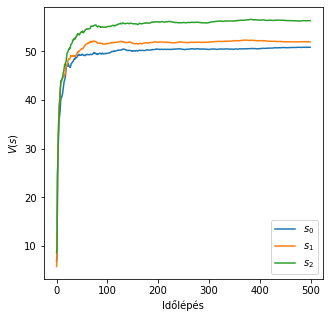

In [5]:
plt.figure(figsize=(5,5))
plt.plot(V_means, label=['$s_0$', '$s_1$', '$s_2$'])
plt.legend(loc='lower right')
plt.xlabel('Időlépés')
plt.ylabel('$V(s)$')
plt.show()

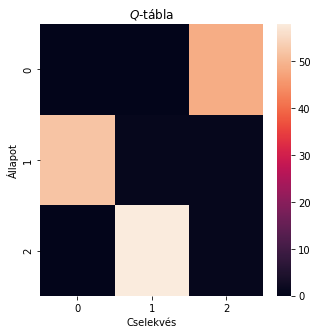

In [6]:
plt.figure(figsize=(5, 5))
plt.title("$Q$-tábla")
sns.heatmap(Q)
plt.xlabel("Cselekvés")
plt.ylabel("Állapot")
plt.show()

---
## Időbeli különbségek

### Politika kiértékelés
<img src="td_policy_eval.png" alt="TD politika kiértékelés" width=1000>

In [7]:
def TD_policy_eval(env, policy, max_i, gamma, alpha):
    V = [np.random.random() for _ in env.ST]  # Állapot-érték vektor inicializálása véletlen értékekkel
    V[env.sT] = 0  # Terminális állapot értékének 0-ra állítása

    for i in range(max_i):
        s = env.s0  # Aktuális állapot állítása a kezdőállapotra

        for t in range(max_i):
            a = policy[s]  # Cselekvés választása a politika szerint
            r, sp = env.step(s, a)  # Cselekvés a környezetben, jutalom és következő állapot megfigyelése
            V[s] = V[s] + alpha * (r + gamma * V[sp] - V[s])  # Állapot-érték függvény frissítése a TD definíció szerint
            s = sp  # Aktuális állapot frissítése
            if s == env.sT:  # Ha az ügynök elérte a terminális állapotot, kilépés
                break
    
    return V

### Politika javítás

<img src="td_policy_improve.png" alt="TD politika javítás" width=1000>

In [8]:
max_i = 500
gamma = 0.98
alpha = 0.1  # Tanulási sebesség
env = Environment()
policy = {s: np.random.choice(env.A[s]) for s in env.ST}
policy[env.sT] = 0
Q = np.random.random(size=(env.n_ST, env.n_A))  # Környezet inicializálása
Q[env.sT, :] = 0  # Terminális állapotból elérhető cselekvések értékének 0-ra állítása
V_tracks = []  # Követési struktúra az állapot-értékeknek
V_means = []  # Követési struktúra az átlagos állapot-értékeknek

for i in range(max_i):
    s = env.s0  # Aktuális állapot kezdőállapotra állítása
    a = policy[s]  # Cselekvés választása a politika szerint

    for t in range(max_i):
        if s == env.sT:  # Ha az ügynök elérte a terminális állapotot, kilépés
            break
        r, sp = env.step(s, a)  # Cselekvés végrehajtása a környezetben, jutalom és következő állapot megfigyelése
        ap = policy[sp]  # Következő cselekvés kiválasztása a következő állapotból a politika szerint
        Q[s][a] = Q[s][a] + alpha * (r + gamma * Q[sp][ap] - Q[s][a])  # Q-tábla frissítése a TD frisssítési szabály szerint
        policy[s] = np.argmax(Q[s])  # Politika frissítése a Q-tábla alapján
        s = sp  # Aktuális állapot következő állapotra állítása
        a = ap  # Aktuális cselekvés következő cselekvésre állítása

    V = TD_policy_eval(env, policy, 100, gamma, alpha)  # Értékfüggvény kiszámítása az aktuális politikával
    V_tracks.append(V)  # Állapot-érték vektor hozzáfűzése a követési struktúrához
    V_means.append(np.mean(np.array(V_tracks), axis=0))  # Átlagos állapot-érték kiszámítása 

print(policy)  # Politika (a terminális állapottal együtt - ez mindenképp 0 lesz)

{0: 2, 1: 0, 2: 1, 3: 0}


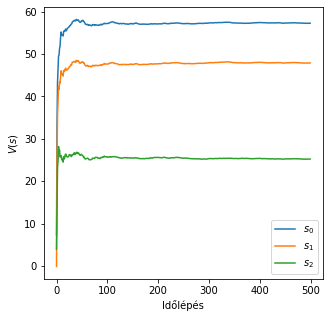

In [9]:
V_means = [arr[:-1] for arr in V_means]
plt.figure(figsize=(5,5))
plt.plot(V_means, label=['$s_0$', '$s_1$', '$s_2$'])
plt.legend()
plt.xlabel('Időlépés')
plt.ylabel('$V(s)$')
plt.show()

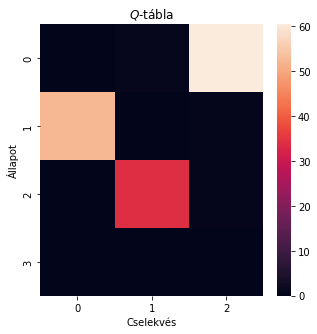

In [10]:
plt.figure(figsize=(5, 5))
plt.title("$Q$-tábla")
sns.heatmap(Q)
plt.xlabel("Cselekvés")
plt.ylabel("Állapot")
plt.show()